In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

### Predict the change in the size of the data engineering and science jobs in the next five years.

In [6]:
experience_df = pd.read_csv('../data/preprocessed-data/normalized csv/experiences.csv', converters={'From': pd.to_datetime})
experience_df = experience_df[(experience_df['title_tag'] != 'internship') & (experience_df['EmploymentType'] != 'Internship')]
experience_df = experience_df[(experience_df['title_tag'] != 'student') & (experience_df['title_tag'] != 'teaching')]
experience_df.head()

,User,CompanyUrl,Company,Title,EmploymentType,From,To,Duration,Location,title_tag
4,-ezz,https://www.linkedin.com/company/30101254/,sonono,software engineer,Full-time,2022-01-01,Present,16.0,"Basel, Switzerland",software
6,-ezz,UNKNOWN,CEL - Consulting Engineering Bureau,senior geotechnical engineer,Full-time,2019-09-01,Aug 2020,12.0,Egypt,NaN
7,1212mohamedtaha,https://www.linkedin.com/company/777868/,Etisalat Misr,big data engineer,Full-time,2022-05-01,Present,12.0,"New Cairo, Cairo, Egypt",data
9,1212mohamedtaha,https://www.linkedin.com/company/2229028/,"The Translation Gate, LLC",english / arabic translator,Freelance,2021-01-01,Mar 2021,3.0,Remote,NaN
10,3omarbadr,https://www.linkedin.com/company/18899346/,ACME SAICO - Integrated Engineering Systems -(...,software engineer,Full-time,2022-09-01,Present,8.0,"Heliopolis, Cairo, Egypt",software


In [32]:
# for each month count cumulative number for each title_tag

df = experience_df.groupby(['title_tag', 'From']).count().reset_index()
df = df[['title_tag', 'From', 'User']]
df.columns = ['title_tag', 'From', 'count']
df['count'] = df['count'].cumsum()
df.head()

,title_tag,From,count
0,AI,2014-06-01,1
1,AI,2015-04-01,2
2,AI,2015-05-01,3
3,AI,2016-03-01,4
4,AI,2016-06-01,5


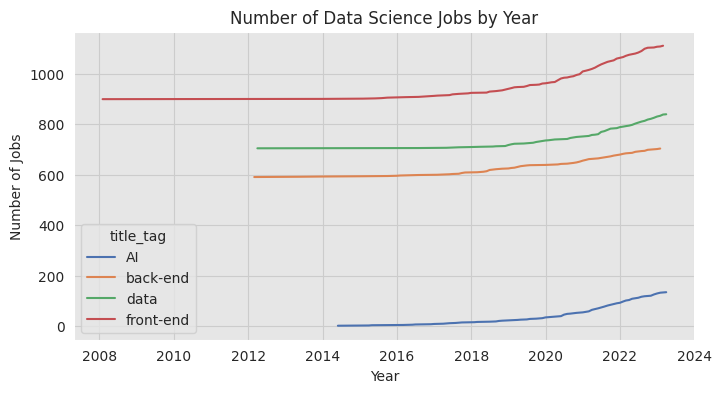

In [33]:
# plot for each title_tag
jobs = ['data', 'front-end', 'back-end', 'AI']
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(x='From', y='count', hue='title_tag', data=df[df['title_tag'].isin(jobs)], ax=ax)
ax.set_title('Number of Data Science Jobs by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Jobs')
plt.show()